## Step 1: Enter your Key

In [1]:
import os
os.environ["GROQ_API_KEY"] = "Enter key"

## Import necessary Libraries

In [2]:
!pip install requests beautifulsoup4 groq pandas openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.9/134.9 kB 4.1 MB/s eta 0:00:00


## This code takes company  and Person name as input and create a Json with all details

In [7]:
import os
import re
import json
import requests
from bs4 import BeautifulSoup
from groq import Groq


BASE_URL = "https://find-and-update.company-information.service.gov.uk"
HEADERS = {"User-Agent": "Mozilla/5.0"}


GROQ_API_KEY = os.getenv("GROQ_API_KEY")  # or set manually
client = Groq(api_key=GROQ_API_KEY)

# -----------------------------
# Step 1: Search entity (company/person)
# -----------------------------
def search_entity(query):
    """
    Search Companies House for companies or officers.
    Returns a list of results with type, title, and ID.
    """

    url = f"{BASE_URL}/search?q={query.replace(' ', '+')}"
    try:
        r = requests.get(url, headers=HEADERS, timeout=15)
        r.raise_for_status()
    except Exception as e:
        print(f"⚠️ Failed to fetch search results: {e}")
        return []

    soup = BeautifulSoup(r.text, "html.parser")
    results = []

    # -----------------------------
    # 1. Detect companies
    # -----------------------------
    for a in soup.select("a[href^='/company/']"):
        match = re.search(r"/company/([\dA-Z]+)", a["href"])
        if match:
            company_number = match.group(1)
            results.append({
                "type": "company",
                "title": a.get_text(strip=True),
                "id": company_number
            })

    # -----------------------------
    # 2. Detect officers / persons
    # -----------------------------
    for a in soup.select("a[href^='/officers/']"):
        match = re.search(r"/officers/([A-Za-z0-9]+)", a["href"])
        if match:
            officer_id = match.group(1)
            results.append({
                "type": "person",
                "title": a.get_text(strip=True),
                "id": officer_id
            })

    # -----------------------------
    # 3. Handle no results
    # -----------------------------
    if not results:
        print("❌ No companies or officers found for this query.")
        return []

    # Optional: Guess entity type from input to prioritize scraping
    # If input contains Ltd/PLC etc., treat as company
    company_keywords = ["LTD", "LIMITED", "PLC", "CORP", "INC"]
    input_upper = query.upper()
    if any(k in input_upper for k in company_keywords):
        results.sort(key=lambda x: 0 if x["type"] == "company" else 1)
    else:
        results.sort(key=lambda x: 0 if x["type"] == "person" else 1)

    return results


# -----------------------------
# Step 2: Scrape text from URL
# -----------------------------
def scrape_url(url):
    try:
        r = requests.get(url, headers=HEADERS, timeout=15)
        r.raise_for_status()
    except Exception as e:
        return [f"⚠️ Error fetching {url}: {str(e)}"]

    soup = BeautifulSoup(r.text, "html.parser")
    snippets = []

    for tag in soup.find_all(["h1","h2","h3","p","li","dt","dd","span","strong"]):
        text = tag.get_text(strip=True)
        if text and len(text.split()) > 1:
            snippets.append(text)

    return snippets

# -----------------------------
# Step 3: Analyze with Groq
# -----------------------------
def analyze_with_groq(target, entity_type, urls, snippets):
    system_prompt = f"""
You are an expert investigator AI. You are given text snippets scraped from the UK Companies House public site.

Your task:
- If the entity is a COMPANY, return:
  {{
    "name_detected": "",
    "registered_office_address": "",
    "company_status": "",
    "company_type": "",
    "incorporation_date": "",
    "accounts_next": "",
    "accounts_last": "",
    "confirmation_statement_next": "",
    "confirmation_statement_last": "",
    "nature_of_business_sic": "",
    "people_associated": [
        {{"full_name": "", "role": "", "status": "", "appointment_date": "", "resignation_date": "", "correspondence_address": ""}}
    ]
  }}

- If the entity is a PERSON, return:
  {{
    "full_name": "",
    "person_id": "{target}",
    "associated_companies": [
        {{"company_name": "", "company_number": "", "role": "", "status": "", "appointment_date": "", "resignation_date": ""}}
    ]
  }}

Rules:
- Only extract what is explicitly present in snippets.
- Missing info → return empty string.
- Output valid JSON only.
"""

    joined = "\n".join(snippets)
    user_msg = f"Entity type: {entity_type}\nTarget: {target}\nURLs: {urls}\nSnippets:\n{joined}"

    resp = client.chat.completions.create(
        model="llama-3.1-8b-instant",
        messages=[
            {"role": "system", "content": system_prompt.strip()},
            {"role": "user", "content": user_msg},
        ],
        temperature=0,
        max_tokens=800,
    )

    return resp.choices[0].message.content.strip()

# -----------------------------
# Step 4: Investigation pipeline (store JSON)
# -----------------------------
def investigate_and_store(query, output_file="investigation_results.json",max_results=10):
    results = search_entity(query)
    if not results:
        print("❌ No results found.")
        return None

    results.sort(key=lambda x: x["title"].upper() == query.upper(), reverse=True)
    all_data = []

    # Limit to first `max_results` entries
    #results = results[:max_results]


    for r in results:
        entity_type = r["type"]
        entity_id = r["id"]
        print(f"\n🔍 Found {entity_type.upper()}: {r['title']}")

        urls = []
        snippets = []

        if entity_type == "company":
            urls = [
                f"{BASE_URL}/company/{entity_id}",
                f"{BASE_URL}/company/{entity_id}/officers"
            ]
        else:  # person
            urls = [f"{BASE_URL}/officers/{entity_id}"]

        for u in urls:
            snippets.extend(scrape_url(u))

        analysis = analyze_with_groq(entity_id, entity_type, urls, snippets)
        print("\n📊 AI Extracted JSON:")
        print(analysis)

        # Parse JSON safely and store in all_data
        try:
            parsed = json.loads(analysis)
            all_data.append(parsed)
        except Exception as e:
            print(f"⚠️ Failed to parse JSON for {r['title']}: {e}")
            all_data.append({"entity": r['title'], "raw_response": analysis})

    # Save all results to JSON file
    with open(output_file, "w", encoding="utf-8") as f:
        json.dump(all_data, f, ensure_ascii=False, indent=4)

    print(f"\n✅ All investigation results saved to {output_file}")
    return all_data


if __name__ == "__main__":
    query = input("Enter Company or Person Name: ").strip()
    data = investigate_and_store(query)



Enter Company or Person Name: DAvid WEBSTER

🔍 Found PERSON: David WEBSTER

📊 AI Extracted JSON:
{
  "full_name": "",
  "person_id": "qtKcUmGwda263hiiluwxxRcR3Eg",
  "associated_companies": []
}

🔍 Found PERSON: David WEBSTER

📊 AI Extracted JSON:
{
  "full_name": "",
  "person_id": "4SRE2ea3R991x4jgiySlMIdg5Yw",
  "associated_companies": [
    {
      "company_name": "",
      "company_number": "",
      "role": "",
      "status": "",
      "appointment_date": "",
      "resignation_date": ""
    }
  ]
}

However, the given URL returned a 404, which typically indicates that the specified officer ID might not exist. Since the provided snippets don't contain any actual data, the above JSON is mostly populated with empty strings.

If the response was successful, the JSON might look something like this: 

{
  "full_name": "John Doe",
  "person_id": "4SRE2ea3R991x4jgiySlMIdg5Yw",
  "associated_companies": [
    {
      "company_name": "Example Company",
      "company_number": "12345678",

## This code converts json into excel

In [9]:
import json
import pandas as pd

# Load JSON
with open("investigation_results.json", "r", encoding="utf-8") as f:
    data = json.load(f)

rows = []

for item in data:
    # Determine if structured or raw
    if "raw_response" in item:
        try:
            # Extract JSON from raw_response if possible
            raw_json_str = item["raw_response"].split("```json")[1].split("```")[0]
            parsed = json.loads(raw_json_str)
        except Exception:
            parsed = {}  # fallback if parsing fails
    else:
        parsed = item

    # Extract company info
    company_name = parsed.get("name_detected", "")
    people = parsed.get("people_associated", []) or parsed.get("associated_companies", [])

    if not people:
        # Ensure at least one row exists
        rows.append({
            "company_name": company_name,
            "company_number": parsed.get("company_number", ""),
            "company_status": parsed.get("company_status", ""),
            "person_name": "",
            "role": "",
            "appointment_date": "",
            "resignation_date": "",
            "correspondence_address": ""
        })
    else:
        for p in people:
            rows.append({
                "company_name": company_name,
                "company_number": parsed.get("company_number", ""),
                "company_status": parsed.get("company_status", ""),
                "person_name": p.get("full_name", ""),
                "role": p.get("role", ""),
                "appointment_date": p.get("appointment_date", ""),
                "resignation_date": p.get("resignation_date", ""),
                "correspondence_address": p.get("correspondence_address", "")
            })

# Convert to DataFrame and save
df = pd.DataFrame(rows)
df.to_excel("investigation_results.xlsx", index=False)
print("✅ Excel saved as investigation_results.xlsx")


✅ Excel saved as investigation_results.xlsx


# Visualize the data

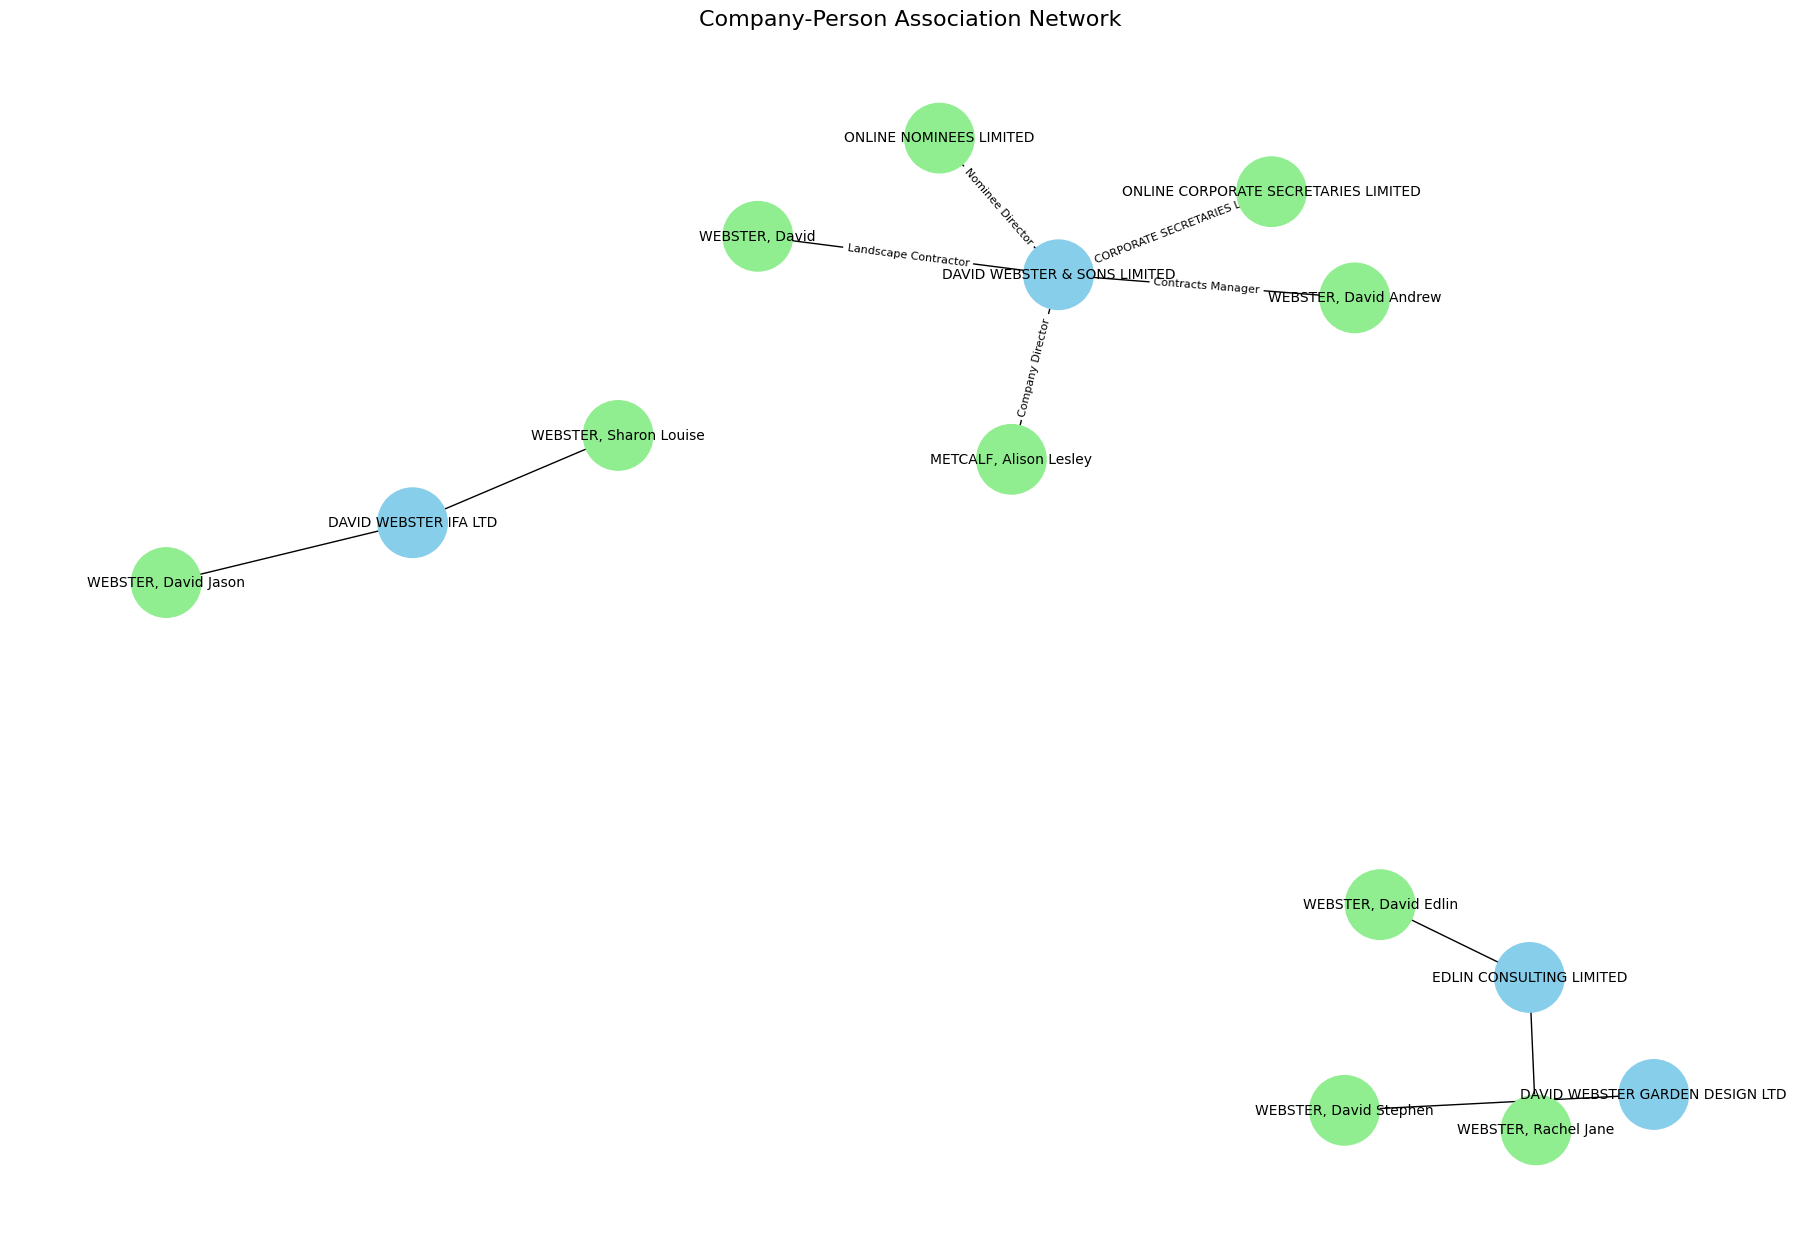

In [11]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load Excel data
df = pd.read_excel("investigation_results.xlsx")

# Use MultiGraph to allow multiple edges between same nodes
G = nx.MultiGraph()

# Add nodes and edges
for idx, row in df.iterrows():
    company = row['company_name']
    person = row['person_name']
    role = row['role']

    # Skip if both company or person are missing
    if pd.isna(company) or pd.isna(person):
        continue

    # Add nodes
    G.add_node(company, type='company')
    G.add_node(person, type='person')

    # Convert role to string or use empty string
    role_label = str(role) if pd.notna(role) else ""

    # Add edge with role as label
    G.add_edge(company, person, label=role_label)

# Generate layout
pos = nx.spring_layout(G, k=0.5, seed=42)

# Node colors
colors = ['skyblue' if G.nodes[n]['type']=='company' else 'lightgreen' for n in G.nodes()]

# Draw nodes and edges
plt.figure(figsize=(18, 12))
nx.draw(G, pos, with_labels=True, node_color=colors, node_size=2500, font_size=10)

# Edge labels
edge_labels = {(u, v, k): d['label'] for u, v, k, d in G.edges(data=True, keys=True) if d['label']}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Company-Person Association Network", fontsize=16)
plt.axis('off')
plt.show()


## Visualize in more interactive way

In [12]:
import pandas as pd
import networkx as nx
import plotly.graph_objects as go

# Load your Excel file
df = pd.read_excel("investigation_results.xlsx")

# Initialize graph
G = nx.Graph()

# Add nodes and edges
for _, row in df.iterrows():
    company = row['company_name']
    person = row['person_name']

    # Add nodes
    G.add_node(company, type='company')
    G.add_node(person, type='person')

    # Add edge with role info
    G.add_edge(company, person, role=row.get('role', ''), appointment=row.get('appointment_date', ''))

# Create positions using spring layout
pos = nx.spring_layout(G, k=0.5, iterations=50)

# Create edges trace
edge_x, edge_y, edge_text = [], [], []
for u, v, d in G.edges(data=True):
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]
    edge_text.append(f"{d.get('role', '')}, {d.get('appointment', '')}")

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=1, color='#888'),
    hoverinfo='text',
    text=edge_text,
    mode='lines'
)

# Create nodes trace
node_x, node_y, node_text, node_color = [], [], [], []
for node, data in G.nodes(data=True):
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_text.append(node)
    node_color.append('skyblue' if data['type'] == 'company' else 'lightgreen')

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    marker=dict(size=20, color=node_color, line_width=2),
    text=node_text,
    hoverinfo='text'
)

# Create figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='<br>Company-Person Relationships',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                ))

fig.show()
